In [1]:
import numpy as np
from numpy.random import default_rng
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns
from typing import NamedTuple, Dict
from sklearn import linear_model

import warnings
warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

## For this Method to work, we must ensure to stay between [0, pi]

## Optimize via the nelder-mead method

In [2]:
def calc_Y(A_in: np.ndarray, u_in: np.ndarray, alpha: float, beta: float) -> np.ndarray:
    """
    Y = cos(alpha + beta*A + u)
    """
    A = np.copy(A_in)
    u = np.copy(u_in)
    return np.cos(alpha + beta*A + u), alpha + beta*A + u

def calc_A(Z_in: np.ndarray,  u_in: np.ndarray, e_in: np.ndarray, gamma: np.ndarray, delta: float) -> np.ndarray:
    """
    A = gamma*Z + delta*u + e
    """
    Z = np.copy(Z_in)
    u = np.copy(u_in)
    e = np.copy(e_in)
    return np.dot(gamma, Z.T) + delta*u + e
        

def generatate_data(n_sample: int, params: np.ndarray,  seed: int, Zdim: int, 
                    Z_noise: float, u_noise: float, e_noise: float):
    rng = default_rng(seed=seed)
    alpha, beta, gamma, delta = params
    
    u = rng.normal(0, u_noise, n_sample)
    e = rng.normal(0, e_noise, n_sample)
    Z = rng.normal(0, Z_noise, [n_sample, Zdim])
    A = calc_A(Z, u, e, gamma, delta) 
    Y = calc_Y(A, u, alpha, beta)
    return u, e, Z, A, Y

def cal_true_effect(a: float, params, u_noise: float, n_MC: int = 10000):
    """
    To estimate true effect
    n_MC affects MC error, seed is fixed!
    """
    rng = default_rng(seed=42)
    alpha, beta, gamma, delta = params
    
    u = rng.normal(0, u_noise, n_MC)
    Y, c= calc_Y(a, u, alpha, beta)
    return np.mean(Y)


def generate_struc_data(params, u_noise: float, a_start: float, a_end: float, n_steps: int = 100, 
                         n_MC: int = 10000):
    """
    from a_start to a_end, calc Y effect
    """
    a_steps = np.linspace(a_start, a_end, n_steps)
    y_struc = np.array([cal_true_effect(a, params, u_noise, n_MC) for a in a_steps])
    return a_steps, y_struc

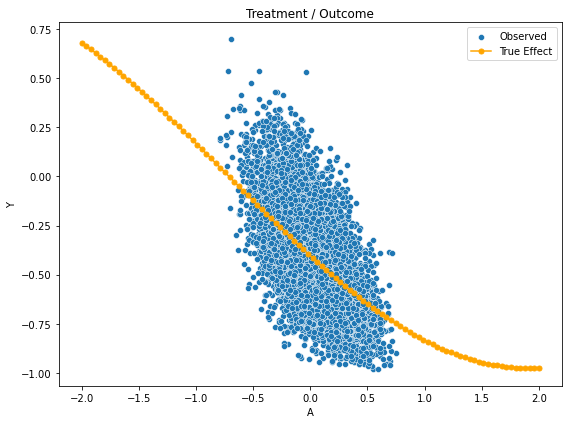

0.7952203534717129 2.9512742179318674


In [3]:
# Sample Parameters
random_seed = 10010
n_sample = 10000
n_MC = 10000
# Number of Instruments
Zdim = 2
# True Parameters
alpha_true = 2
beta_true = 0.6
gamma_true = np.array([0.1, 0.02])
delta_true = 0.1 
params_true = np.array([alpha_true, beta_true, gamma_true, delta_true])
# Noise Parameters
u_noise = np.sqrt(0.05)
e_noise = np.sqrt(0.05)
Z_noise = np.sqrt(0.1)

u_data, e_data, Z_data, A_data, Y_data = generatate_data(n_sample, params_true,  seed=random_seed, Zdim = Zdim, 
                                                         Z_noise = Z_noise, u_noise = u_noise, e_noise = e_noise)

# generate structural Data (True Effect)
a_steps, y_struc = generate_struc_data(params_true, u_noise = u_noise, a_start=-2, a_end=2, n_steps = 100, 
                                        n_MC = n_MC)

# Plot Results
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))

sns.scatterplot(x=A_data, y=Y_data[0], label='Observed', ax=ax1)
ax1.plot(a_steps, y_struc, color='orange', marker='o', label="True Effect", markersize=5)
ax1.set_title('Treatment / Outcome')
ax1.set_xlabel('A')
ax1.set_ylabel('Y')
ax1.legend()

# fig.suptitle('Visualization')
plt.tight_layout()
plt.show()
print(min(Y_data[1]), max(Y_data[1]))

## GMM

In [4]:
def calc_error(Y_in:np.ndarray, A_in: np.ndarray, alpha: float, beta: float) -> np.ndarray:
    """
    error
    """
    A = np.copy(A_in)
    Y = np.copy(Y_in)
    return np.arccos(Y) - alpha  - beta*A

def g_vec(Y_in, A_in, Z_in, params_in):
    # Var
    A = np.copy(A_in)
    Y = np.copy(Y_in)
    Z = np.copy(Z_in)
    # calc error (problem specific)
    alpha_in, beta_in = params_in
    alpha = np.copy(alpha_in)
    beta = np.copy(beta_in)
    
    # new
    err = calc_error(Y, A, alpha, beta).reshape(-1, 1)
    g = np.mean(Z * err, axis = 0).reshape(-1, 1)
    return g

In [5]:
def g_grad(g_vec, Y_in, A_in, Z_in, params_in):
    # Var
    A = np.copy(A_in)
    Z = np.copy(Z_in)
    Y = np.copy(Y_in)
    # calc error (problem specific)
    alpha_in, beta_in = params_in
    alpha = np.copy(alpha_in)
    beta = np.copy(beta_in)
    
    # parameter gradients
    grad_alpha = np.array([1]*len(A))
    grad_beta = A
    grad_param = np.array([grad_alpha, grad_beta]).T
    #print("param", grad_param.shape)
    
    # loss fct gradient
    error = calc_error(Y, A, alpha, beta).reshape(-1, 1)
    
    grad_loss = np.sum(-2*error*(Z**2), axis=1).reshape(-1, 1)
    
    # final gradient
    g_grad = np.squeeze(np.mean(grad_loss*grad_param, axis=0))
    #print("g_grad", g_grad.shape)

    return g_grad

In [6]:
def criterion(params, *var): 
    """
    c(params) = g.T(params) W_hat g(params)
    Aim: min c in params
    """
    Y, var_model, var_inst, W_hat = var
    g = g_vec(Y, var_model, var_inst, params)
    crit_val = np.dot(np.dot(g.T, W_hat), g)
    grad = g_grad(g, Y, var_model, var_inst, params)
    
    return crit_val, grad

In [7]:
# True Parameters
params_true = np.array([alpha_true, beta_true])
print("True", params_true)
# Initial Parameters
alpha_init = 0
beta_init = 0

params_init = np.array([alpha_init, beta_init])

W_hat = np.eye(2)


var_model = A_data
var_inst = Z_data
y_gmm = Y_data[0]
gmm_args = (y_gmm, var_model, var_inst, W_hat)
print("Initial Result:", criterion(params_init, *gmm_args))

results = opt.minimize(criterion, params_init, args=(gmm_args), jac=True, method='nelder-mead',
                       tol=1e-8, options  = {"maxiter":100000, "disp":True})
results

True [2.  0.6]
Initial Result: (array([[0.00017035]]), array([-0.79654012, -0.01840076]))


C:\Users\Benedikt\Anaconda3\envs\standard\lib\site-packages\scipy\optimize\_minimize.py:550: RuntimeWarning: Method nelder-mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 98
         Function evaluations: 192


 final_simplex: (array([[1.88240682, 0.55570978],
       [1.88240681, 0.55570977],
       [1.88240682, 0.55570978]]), array([1.39100783e-21, 1.39939860e-21, 1.60989846e-21]))
           fun: 1.3910078326299781e-21
       message: 'Optimization terminated successfully.'
          nfev: 192
           nit: 98
        status: 0
       success: True
             x: array([1.88240682, 0.55570978])

In [8]:
def cal_pred_effect(a_in: float, params_pred):
    """
    To estimate pred effect
    """
    a = np.copy(a_in)
    alpha, beta = params_pred
    return np.cos(alpha + beta*a)

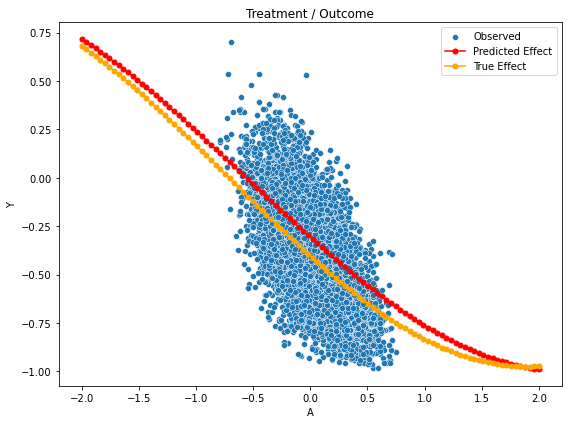

In [9]:
params_pred = results.x
# params_pred = [alpha_true, beta_true]
y_pred = [cal_pred_effect(a, params_pred) for a in a_steps]

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))

sns.scatterplot(x=A_data, y=Y_data[0], label='Observed', ax=ax1)
ax1.plot(a_steps, y_pred, color='red', marker='o', label="Predicted Effect", markersize=5)
ax1.plot(a_steps, y_struc, color='orange', marker='o', label="True Effect", markersize=5)


ax1.set_title('Treatment / Outcome')
ax1.set_xlabel('A')
ax1.set_ylabel('Y')
ax1.legend()


# fig.suptitle('Visualization')
plt.tight_layout()
plt.show()

### Averaged over 20 seeds with different sample sizes

In [10]:
seeds = [5305, 7165, 8789, 1552, 5635, 8970, 6842, 7561, 1418, 7902, 9086, 1384, 3412, 1810, 7375, 4600, 6932, 3199, 4768, 69]
results = []
n_sample_seeds = 5000
print("Number of Samples", n_sample_seeds)

alpha_true = 2
beta_true = 0.6
gamma_true = np.array([0.1, 0.02])
delta_true = 0.1 
params_true = np.array([alpha_true, beta_true, gamma_true, delta_true])
print("True parameters", [alpha_true, beta_true])

alpha_init = 0
beta_init = 0
params_init = np.array([alpha_init, beta_init])
print("Initial Parameters", params_init)

# Noise
u_noise = np.sqrt(0.05)
e_noise = np.sqrt(0.05)
Z_noise = np.sqrt(0.1)
    
for r_seed in seeds:
    u_data, e_data, Z_data, A_data, Y_data = generatate_data(n_sample=n_sample_seeds, params=params_true,  
                                                             seed=r_seed, Zdim = Zdim, 
                                                             Z_noise = Z_noise, u_noise = u_noise, e_noise = e_noise)

    W_hat = np.eye(2)


    var_model = A_data
    var_inst = Z_data
    y_gmm = Y_data[0]
    gmm_args = (y_gmm, var_model, var_inst, W_hat)

    res = opt.minimize(criterion, params_init, args=(gmm_args), jac=True, method='nelder-mead',
                           tol=1e-8, options  = {"maxiter":100000, "disp":False})

    #print(min(Y_data[1]), max(Y_data[1]))
    results.append(res.x)
    print(f"Seed {r_seed} results:", res.x)

final_results = np.mean(np.array(results), axis=0)
print("Predicted (Averaged) Parameters", final_results)
# 1000: [2.11738299 0.81469785]
### 5000: [1.93551837 0.60385239] (best!!!)
### 10000: [1.89652635 0.62604561] (startng to suffer from same problem as below)
### 100000: [2.727314   0.62718443] (I gues with so many sample so many weird stuff can happen that 
                                    # too many var fall out of bound)

Number of Samples 5000
True parameters [2, 0.6]
Initial Parameters [0 0]


C:\Users\Benedikt\Anaconda3\envs\standard\lib\site-packages\scipy\optimize\_minimize.py:550: RuntimeWarning: Method nelder-mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


Seed 5305 results: [2.33482214 0.58389089]
Seed 7165 results: [1.0717568  0.59962398]
Seed 8789 results: [2.25280209 0.44922949]
Seed 1552 results: [2.85517396 0.48281601]
Seed 5635 results: [1.86535395 0.59108094]
Seed 8970 results: [3.06327853 0.76375762]
Seed 6842 results: [1.50971554 0.67374461]
Seed 7561 results: [2.19843481 0.75162208]
Seed 1418 results: [1.53249493 0.49858396]
Seed 7902 results: [1.96186052 0.56247856]
Seed 9086 results: [2.05123401 0.36563978]
Seed 1384 results: [1.56074378 0.80844846]
Seed 3412 results: [1.64028933 0.51612247]
Seed 1810 results: [1.66351491 0.5035001 ]
Seed 7375 results: [1.76299642 0.84860461]
Seed 4600 results: [1.84526652 0.92068833]
Seed 6932 results: [2.19919658 0.57772391]
Seed 3199 results: [1.45875177 0.48857673]
Seed 4768 results: [1.86786599 0.53988536]
Seed 69 results: [2.01481483 0.55102998]
Predicted (Averaged) Parameters [1.93551837 0.60385239]


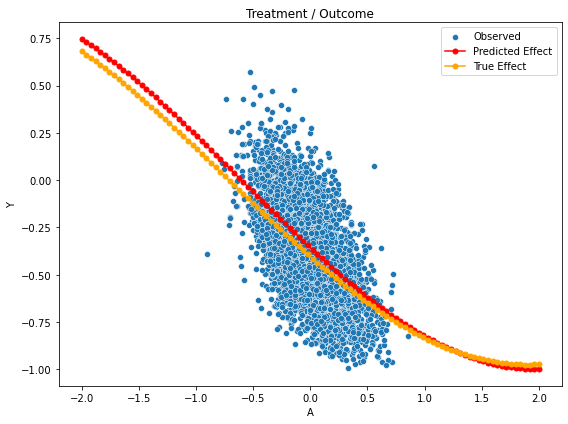

In [11]:
params_pred = final_results
y_pred = [cal_pred_effect(a, params_pred) for a in a_steps]

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))

sns.scatterplot(x=A_data, y=Y_data[0], label='Observed', ax=ax1)
ax1.plot(a_steps, y_pred, color='red', marker='o', label="Predicted Effect", markersize=5)
ax1.plot(a_steps, y_struc, color='orange', marker='o', label="True Effect", markersize=5)


ax1.set_title('Treatment / Outcome')
ax1.set_xlabel('A')
ax1.set_ylabel('Y')
ax1.legend()


# fig.suptitle('Visualization')
plt.tight_layout()
plt.show()

### Problem

In [12]:
y_cos = Y_data[0]
y_lin = Y_data[1]

not_equal = np.arccos(y_cos) != y_lin
print(np.sum(not_equal))

# print the values in a and b that are not the same
print('Values in a that are not the same: ', y_cos[not_equal])
print('Values in b that are not the same: ', y_lin[not_equal])

2
Values in a that are not the same:  [-0.52902966 -0.99383633]
Values in b that are not the same:  [2.12825302 3.03050699]
